# Dynamic Programming - Group 'Lost in Optimization' - Main python notebook

Install dependencies and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

#%pip install EconModel
#%pip install ConSav
#%pip install quantecon

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import os
nb.set_num_threads(4) #perhaps set to 8

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Initial solve of the models

Set amount of periods:

In [2]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


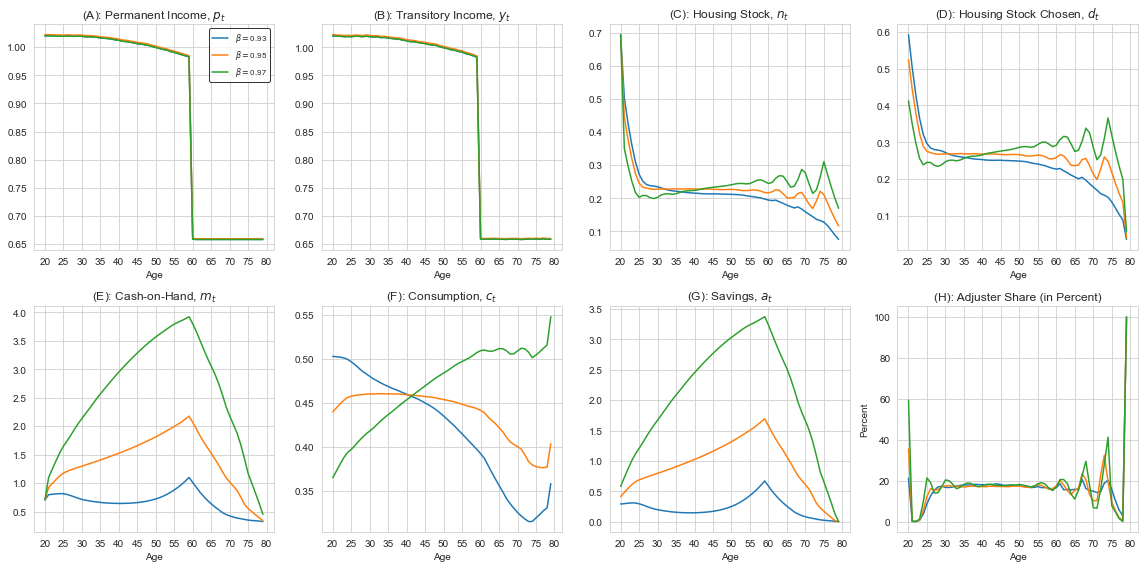

In [3]:
model_negm.lifecycle()

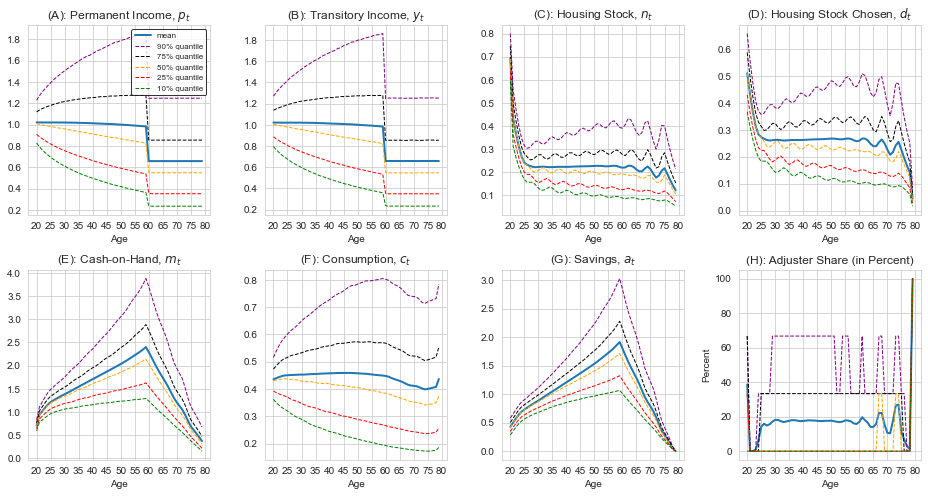

In [4]:
model_negm.lifecycle_rand()

# Plots To be Put in The Paper

In [5]:
model_negm_baseline = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','delta':0.02,'do_print':False})
model_negm_baseline.precompile_numba() # solve with very coarse grids
model_negm_baseline.solve()
model_negm_baseline.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


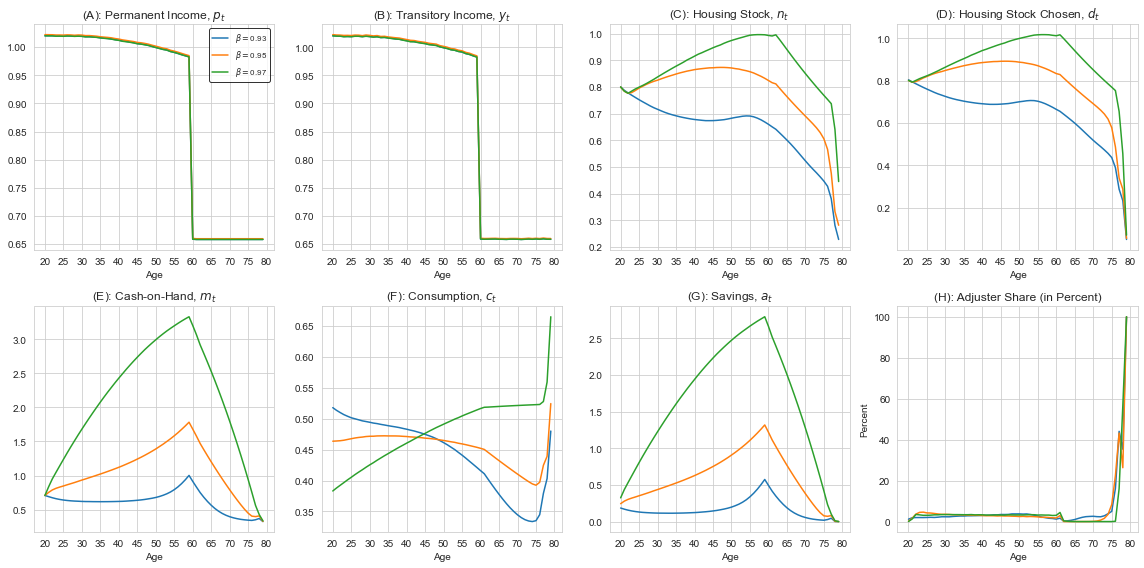

In [6]:
model_negm_baseline.lifecycle()

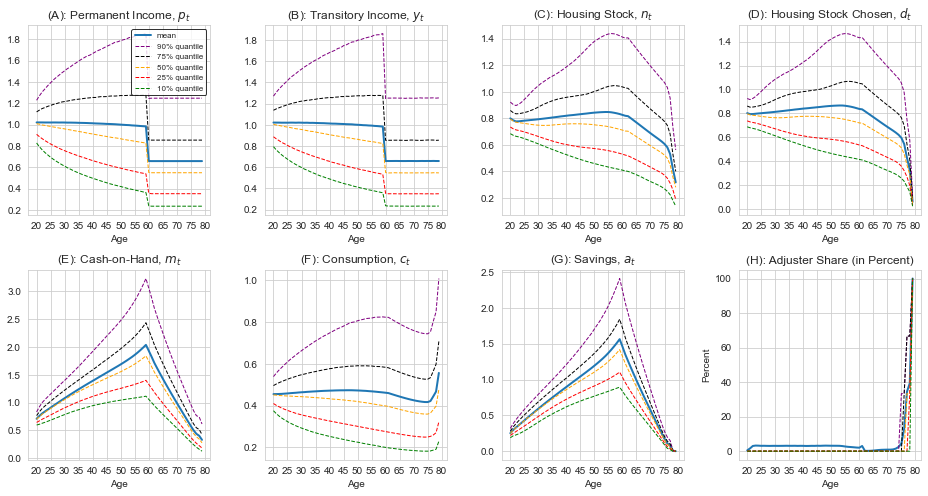

In [7]:
model_negm_baseline.lifecycle_rand()

# Tax Shocks (using $\delta$ =0.02)

## Transitory Anticipated Tax Increase

Create a copy of the original model solve with NEGM and implement anticipated transitory tax increase in period 20 (i.e. 21):

In [8]:
model_negm_trans5pct = model_negm_baseline.copy()
model_negm_trans5pct.par.tax_rate_vec[20] = model_negm_baseline.par.tax_rate_vec[20]*1.05

Check tax array to see that a transitory shock has been implemented:

In [9]:
# ensuring tax has hikened
model_negm_trans5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  ])

Solve and simulate new model with anticipated transitory shock:

In [10]:
model_negm_trans5pct.solve()
model_negm_trans5pct.simulate()

solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_32099/759048387.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


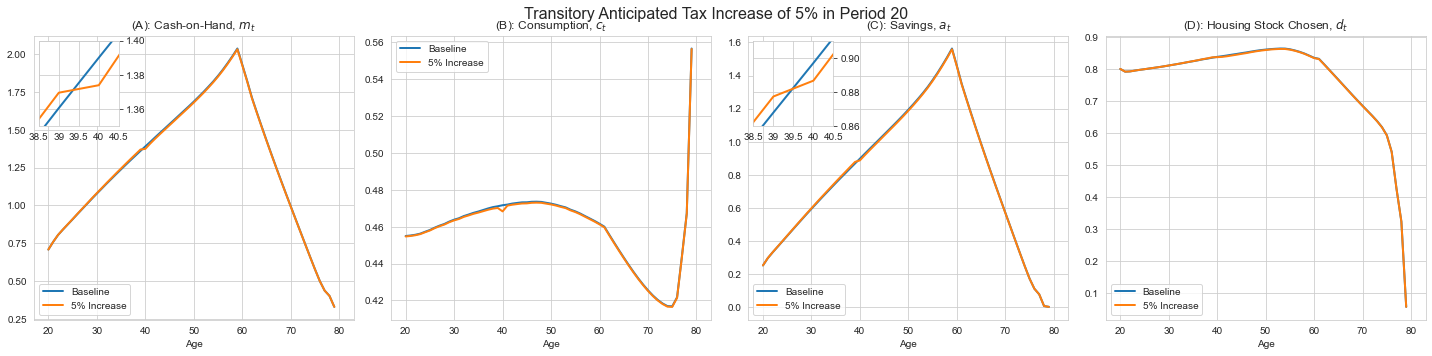

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_trans5pct = model_negm_trans5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Housing Stock Chosen, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Transitory Anticipated Tax Increase of 5% in Period 20", fontsize=16)

age = np.arange(par.T)

for i, (simvar, simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar)
    simdata_trans5pct = getattr(sim_trans5pct, simvar)
    
    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label='Baseline')
    axs[i].plot(age, np.mean(simdata_trans5pct, axis=(1,2)), lw=2, label='5% Increase')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(simvarlatex)

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    new_xticks = xticks + 20
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

    # create zoom-in inset plot on the first graph
    if i == 0 or i == 2:
        axs[i].legend(loc='lower left')
        
        axins = inset_axes(axs[i], width="25%", height="30%", loc='upper left')
        axins.plot(age, np.mean(simdata, (1,2)), lw=2)
        axins.plot(age, np.mean(simdata_trans5pct, (1,2)), lw=2)

        # specify the limits for the zoomed-in plot
        axins.set_xlim(18.5, 20.5)
        axins.set_ylim(1.35, 1.4) if i == 0 else axins.set_ylim(0.86, 0.91)

        # Move labels to right
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position("right")

        # Change x-axis labels for inset axes to show 20 years later
        xticks = axins.get_xticks()
        new_xticks = xticks + 20
        axins.set_xticks(xticks[::2])
        axins.set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks[::2]])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the layout so that title does not overlap with the top plot
plt.show()


## Permanent Anticipated Tax Increase

Create a copy of the original model solve with NEGM and anticipated permanent tax increase in period 20 (i.e., 21):

In [12]:
model_negm_5pct = model_negm_baseline.copy()
model_negm_5pct.par.tax_rate_vec[20:] = model_negm_baseline.par.tax_rate_vec[20:]*1.05

Check tax array to see that a permanent increase has been implemented:

In [13]:
model_negm_5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355])

Solve and simulate new model with permanent shock:

In [14]:
model_negm_5pct.solve()
model_negm_5pct.simulate()

solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


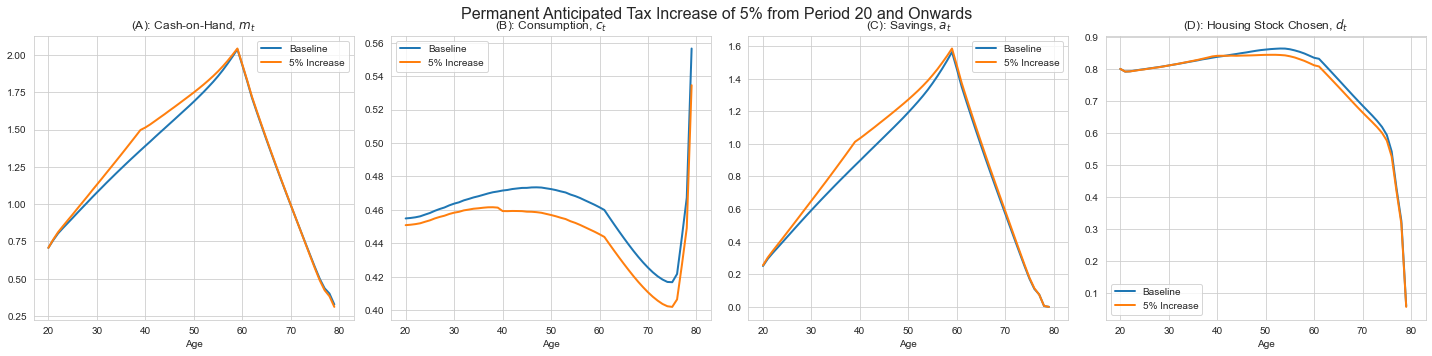

In [15]:
# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_5pct = model_negm_5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Housing Stock Chosen, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim,simvar)
    simdata_5pct = getattr(sim_5pct,simvar)

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label='Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2, label='5% Increase')

    
    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

## Uanticipated Permanent Tax Increase

Create a copy of the original model solve with EGM and *unanticipated* permanent tax increase in period 20 (i.e., 21):

In [16]:
model_unanticipated5pct = model_negm_baseline.copy()

Replace the periods after 20 from the old_tax simulation with the new_tax simulation

In [17]:
for var in ['m', 'c', 'a','d']:
    sim_old = getattr(model_negm_baseline.sim, var)
    sim_new = getattr(model_negm_5pct.sim, var)
    sim_combined = np.copy(sim_old)  # Create a copy of the old simulation
    sim_combined[20:] = sim_new[20:]  # Replace the periods after 20 with the new simulation

    # Set the combined simulation in the original model
    setattr(model_unanticipated5pct.sim, f'{var}', sim_combined)

Checking They Jump to Correct (New) Optimal Path:

In [18]:
print(
    np.mean(model_negm_baseline.sim.c[10,:,0]),
    np.mean(model_unanticipated5pct.sim.c[10,:,0]),
    np.mean(model_unanticipated5pct.sim.c[30,:,0]),
    np.mean(model_negm_5pct.sim.c[30,:,0]),
)

0.4449063573561074 0.4449063573561074 0.6345369908137597 0.6345369908137597


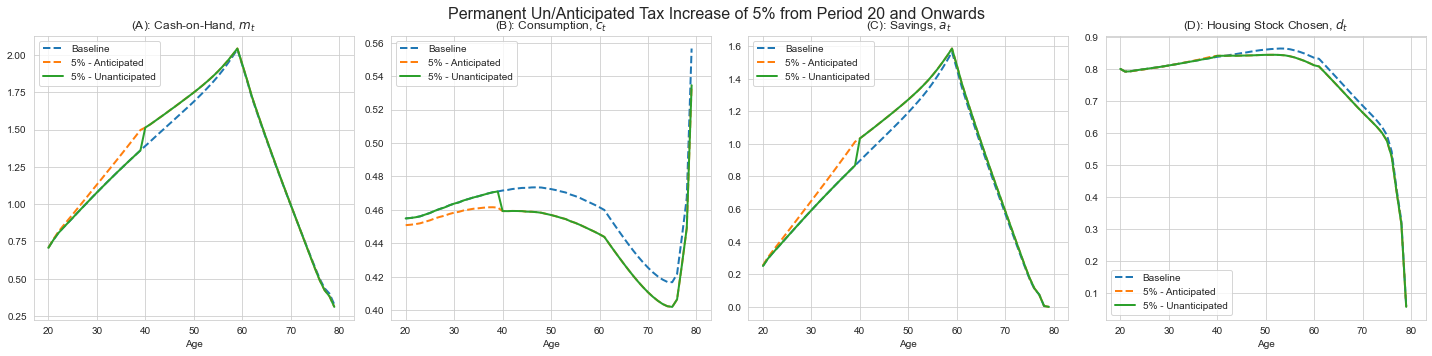

In [19]:
# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_5pct = model_negm_5pct.sim
sim_unanticipated = model_unanticipated5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Housing Stock Chosen, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Un/Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar)
    simdata_5pct = getattr(sim_5pct, simvar)
    simdata_unanticipated = getattr(sim_unanticipated, simvar)  # data from combined model

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, linestyle = '--',label='Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2,linestyle = '--', label='5% - Anticipated')
    axs[i].plot(age, np.mean(simdata_unanticipated, axis=(1,2)), lw=2, label='5% - Unanticipated')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

Combine graphs into one plot:

In [20]:
def get_key(varname):
        """ fetch name associated with variable """
        variabel_name = {
                            "Transitory Anticipated Tax Increase of 5% in Period 20"                                :0,
                            "Permanent Anticipated Tax Increase of 5% in Period 20 and Onwards"                    :1, 
                            "Permanent Un/Anticipated Tax Increase of 5% from Period 20 and Onwards"                 :2
                            }
        
        for key, value in variabel_name.items():
            if value == varname:
                 return key

/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_32099/2096139988.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


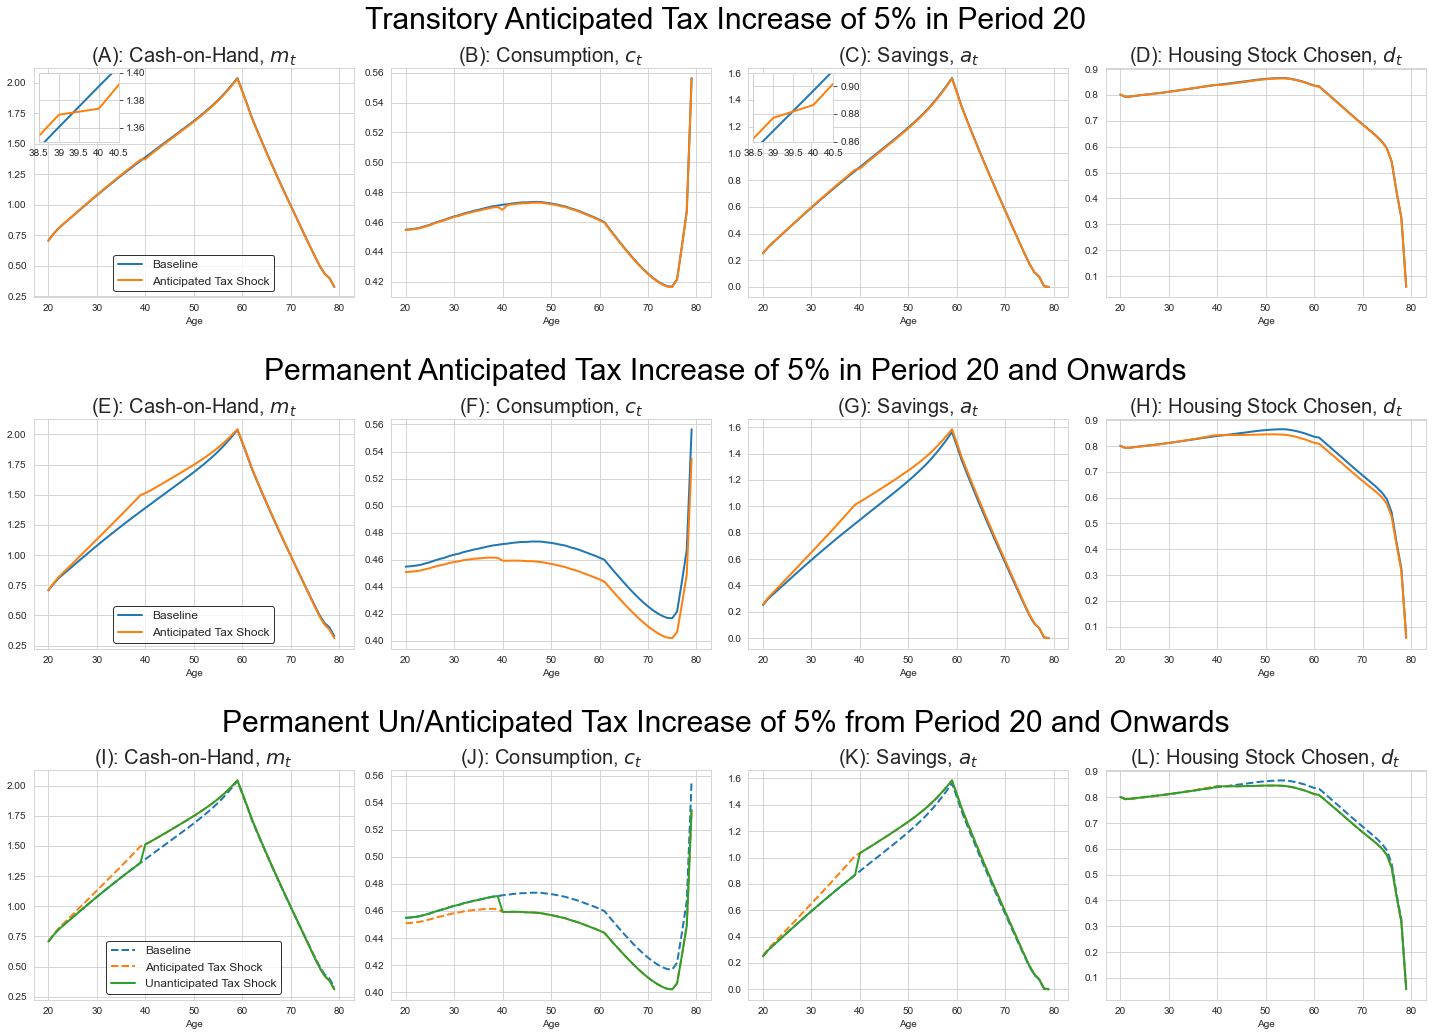

In [21]:
# a. initiate figure
fig, big_axes = plt.subplots( figsize=(20,15), nrows=3, ncols = 1)

for cols, big_ax in enumerate(big_axes):
    big_ax.axis('off')
    for cols,big_ax in enumerate(big_axes):
        big_ax.set_title(f'{get_key(cols)} \n', size = 30, color = 'black')

# b. create subplots
# row 1: "Transitory Anticipated Tax Increase of 5% in Period 20"

# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_trans5pct = model_negm_trans5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Housing Stock Chosen, $d_t$')]

# Create subplots within the large figure instead of creating a new figure
axs = [fig.add_subplot(3, len(simvarlist), i+1) for i in range(len(simvarlist))]

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim,simvar)
    simdata_trans5pct = getattr(sim_trans5pct,simvar)

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label='Baseline')
    axs[i].plot(age, np.mean(simdata_trans5pct, axis=(1,2)), lw=2, label='Anticipated Tax Shock')

    if i == 0:
        legend = axs[i].legend(frameon=True,fontsize=12, loc='lower center')
        frame = legend.get_frame()
        frame.set_edgecolor('black')
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}', fontsize=20)

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

    # create zoom-in inset plot on the first graph
    if i == 0 or i == 2:
        axins = inset_axes(axs[i], width="25%", height="30%", loc='upper left')
        axins.plot(age, np.mean(simdata, (1,2)), lw=2)
        axins.plot(age, np.mean(simdata_trans5pct, (1,2)), lw=2)

        # specify the limits for the zoomed-in plot
        axins.set_xlim(18.5, 20.5)
        axins.set_ylim(1.35, 1.4) if i == 0 else axins.set_ylim(0.86, 0.91)

        # Move labels to right
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position("right")

        # Change x-axis labels for inset axes to show 20 years later
        xticks = axins.get_xticks()
        new_xticks = xticks + 20
        axins.set_xticks(xticks[::2])
        axins.set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks[::2]])


# row 2: "Transitory Anticipated Tax Increase of 5% in Period 20 and Onwards"

# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_5pct = model_negm_5pct.sim

simvarlist = [('m','(E): Cash-on-Hand, $m_t$'),
              ('c','(F): Consumption, $c_t$'),
              ('a','(G): Savings, $a_t$'),
              ('d','(H): Housing Stock Chosen, $d_t$')]

# Create subplots within the large figure instead of creating a new figure
axs = [fig.add_subplot(3, len(simvarlist), i+5) for i in range(len(simvarlist))]

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim,simvar)
    simdata_5pct = getattr(sim_5pct,simvar)

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label='Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2, label='Anticipated Tax Shock')

    if i == 0:
        legend = axs[i].legend(frameon=True,fontsize=12, loc='lower center')
        frame = legend.get_frame()
        frame.set_edgecolor('black')
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}', fontsize=20)

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

# row 3: "Permanent Un/Anticipated Tax Increase of 5% from Period 20 and Onwards"

# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_5pct = model_negm_5pct.sim
sim_unanticipated = model_unanticipated5pct.sim

simvarlist = [('m','(I): Cash-on-Hand, $m_t$'),
              ('c','(J): Consumption, $c_t$'),
              ('a','(K): Savings, $a_t$'),
              ('d','(L): Housing Stock Chosen, $d_t$')]

# Create subplots within the large figure instead of creating a new figure
axs = [fig.add_subplot(3, len(simvarlist), i+9) for i in range(len(simvarlist))]

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar)
    simdata_5pct = getattr(sim_5pct, simvar)
    simdata_unanticipated = getattr(sim_unanticipated, simvar)  # data from combined model

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, linestyle = '--',label='Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2,linestyle = '--', label='Anticipated Tax Shock')
    axs[i].plot(age, np.mean(simdata_unanticipated, axis=(1,2)), lw=2, label='Unanticipated Tax Shock')

    if i == 0:
        legend = axs[i].legend(frameon=True,fontsize=12, loc='lower center')
        frame = legend.get_frame()
        frame.set_edgecolor('black')
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}', fontsize=20)

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

if not os.path.exists("../plots"):
    os.makedirs("../plots")
    
plt.savefig("../plots/two_asset_TaxShocks.pdf", bbox_inches='tight')

plt.show()

# MPC

In [22]:
# unpack 
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sol = model_negm_baseline.sol

### MPC Over the Life Cycle

In [23]:
# define stages
stages = {
    'aggregate': (slice(None), slice(None), slice(None)),
    'working': (slice(model_negm.par.Tr-1), slice(None), slice(None)),
    'retirement': (slice(model_negm.par.Tr, None), slice(None), slice(None)),
}

# number of betas (assuming 3, adjust according to your data)
num_betas = 3

# store results in a dictionary
results = {}

# aggregate across all betas
for stage_name, stage_slice in stages.items():
    # calculate and store the mean
    results[f'mean_mpc_{stage_name}'] = np.mean(model_negm_baseline.sim.mpc[stage_slice]) * 100

# mean values for each beta index
for beta in range(num_betas):
    for stage_name, stage_slice in stages.items():
        # update the slice for the current beta
        beta_slice = (stage_slice[0], beta, stage_slice[2])
        # calculate and store the mean
        results[f'mean_mpc_{stage_name}_beta{beta}'] = np.mean(model_negm_baseline.sim.mpc[beta_slice]) * 100

# access results
for key, value in results.items():
    print(f'{key}: {value:.1f} pct.')

mean_mpc_aggregate: 14.8 pct.
mean_mpc_working: 8.5 pct.
mean_mpc_retirement: 27.6 pct.
mean_mpc_aggregate_beta0: 22.2 pct.
mean_mpc_working_beta0: 14.8 pct.
mean_mpc_retirement_beta0: 37.2 pct.
mean_mpc_aggregate_beta1: 12.3 pct.
mean_mpc_working_beta1: 6.0 pct.
mean_mpc_retirement_beta1: 24.8 pct.
mean_mpc_aggregate_beta2: 10.0 pct.
mean_mpc_working_beta2: 4.5 pct.
mean_mpc_retirement_beta2: 20.8 pct.


### MPC for Different Cohorts

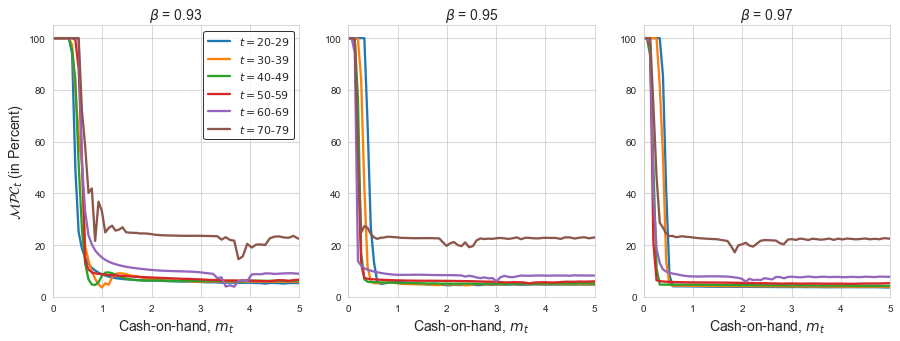

In [24]:
from consav import linear_interp

# unpack 
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sol = model_negm_baseline.sol

p_bar = np.mean(sim.p,axis=1)
n_bar = np.mean(sim.n,axis=1)

# allocate memory
c0 = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))
c1 = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))
mpc = np.zeros(shape=(par.T,len(par.Betas), len(par.grid_m)))

for t in range(par.T):
    for b in range(len(par.Betas)):
        for i,m in enumerate(par.grid_m):
            c0[t,b,i] = linear_interp.interp_3d(
                    par.grid_p,par.grid_n,par.grid_m,sol.c_keep[t,b],
                    p_bar[t,b],n_bar[t,b],m)
            c1[t,b,i] = linear_interp.interp_3d(
                    par.grid_p,par.grid_n,par.grid_m,sol.c_keep[t,b],  
                    p_bar[t,b],n_bar[t,b],m+par.eps)
            mpc[t,b,i] = (c1[t,b,i]-c0[t,b,i])/par.eps

fig, axs = plt.subplots(1, len(par.Betas), figsize=(15, 5))

for b in range(len(par.Betas)):
    for t in np.arange(0,par.T,10):
        axs[b].plot(par.grid_m, np.mean(mpc[t:t+9,b,:]*100,axis=0), label='$t={}$-${}$'.format(t+par.Tmin,t+par.Tmin+9), lw=2.3)
        axs[b].set_xlim([0, 5])  # sets x-axis limit
        axs[b].set_ylim([0, 105])  # sets y-axis limit
        axs[b].set_title(r'$\beta$ = {:.2f}'.format(par.Betas[b]), fontsize=14)  # sets title for each subplot
        axs[b].set_xlabel('Cash-on-hand, $m_t$',fontsize=14)
        
        # Add legend to the first plot
        if b == 0:
            legend = axs[b].legend(fontsize=11, frameon=True)  # creates legend with frame
            frame = legend.get_frame()  # gets the legend frame
            frame.set_edgecolor('black')  # sets the legend frame edge color
            axs[b].set_ylabel('$\mathcal{MPC}_t$ (in Percent)',fontsize=14) 

if not os.path.exists("../plots"):
    os.makedirs("../plots")
    
plt.savefig("../plots/two_asset_WealthMPC.pdf", bbox_inches='tight')

plt.show()

### MPC for Interest Spread

In [25]:
model_negm_extended = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','delta':0.02,'do_print':False})
model_negm_extended.par.R_housing = model_negm_extended.par.R + model_negm_extended.par.R_premium
model_negm_extended.precompile_numba() # solve with very coarse grids
model_negm_extended.solve()
model_negm_extended.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


Check:

In [26]:
model_negm_extended.par.R_housing

1.08

In [27]:
# unpack 
par = model_negm_extended.par
sim = model_negm_extended.sim
sol = model_negm_extended.sol

In [28]:
# define stages
stages = {
    'aggregate': (slice(None), slice(None), slice(None)),
    'working': (slice(model_negm.par.Tr-1), slice(None), slice(None)),
    'retirement': (slice(model_negm.par.Tr, None), slice(None), slice(None)),
}

# number of betas (assuming 3, adjust according to your data)
num_betas = 3

# store results in a dictionary
results = {}

# aggregate across all betas
for stage_name, stage_slice in stages.items():
    # calculate and store the mean
    results[f'mean_mpc_{stage_name}'] = np.mean(model_negm_extended.sim.mpc[stage_slice]) * 100

# mean values for each beta index
for beta in range(num_betas):
    for stage_name, stage_slice in stages.items():
        # update the slice for the current beta
        beta_slice = (stage_slice[0], beta, stage_slice[2])
        # calculate and store the mean
        results[f'mean_mpc_{stage_name}_beta{beta}'] = np.mean(model_negm_extended.sim.mpc[beta_slice]) * 100

# access results
for key, value in results.items():
    print(f'{key}: {value:.1f} pct.')

mean_mpc_aggregate: 24.5 pct.
mean_mpc_working: 19.1 pct.
mean_mpc_retirement: 35.6 pct.
mean_mpc_aggregate_beta0: 32.6 pct.
mean_mpc_working_beta0: 29.5 pct.
mean_mpc_retirement_beta0: 39.2 pct.
mean_mpc_aggregate_beta1: 24.7 pct.
mean_mpc_working_beta1: 19.1 pct.
mean_mpc_retirement_beta1: 36.1 pct.
mean_mpc_aggregate_beta2: 16.3 pct.
mean_mpc_working_beta2: 8.7 pct.
mean_mpc_retirement_beta2: 31.6 pct.


# Model Augmented with Return on Housing

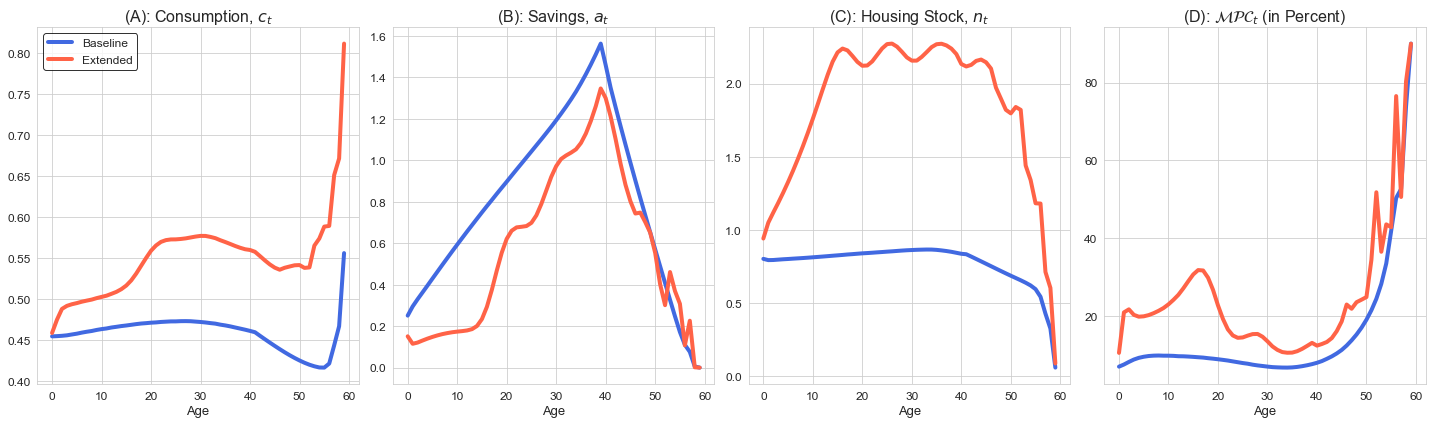

In [29]:
# a. unpack
par_baseline = model_negm_baseline.par
sim_baseline = model_negm_baseline.sim

par_extended = model_negm_extended.par
sim_extended = model_negm_extended.sim

# initiate figure
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

for i, (var, title) in enumerate([('c', 'Consumption, $c_t$'), ('a', 'Savings, $a_t$'), ('d', 'Housing Stock, $n_t$'), ('mpc', '$\mathcal{MPC}_t$ (in Percent)')]):
    baseline = np.mean(getattr(sim_baseline, var), axis=(1, 2))
    extended = np.mean(getattr(sim_extended, var), axis=(1, 2))
    if var == 'mpc':
        baseline *= 100
        extended *= 100
    axs[i].plot(age, baseline, lw=4, color='royalblue', label='Baseline')
    axs[i].plot(age, extended, lw=4, color='tomato', label='Extended')
    axs[i].set_xlabel('Age', fontsize=13)
    axs[i].set_title(f'({chr(65 + i)}): {title}', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=12)

    if var in ['c']:
        legend = axs[i].legend(frameon=True, fontsize=12)
        frame = legend.get_frame()
        frame.set_edgecolor('black')

# e. save plot
if not os.path.exists("../plots"):
    os.makedirs("../plots")

plt.tight_layout()
plt.savefig("../plots/two_asset_c_a_n_mpc.pdf", bbox_inches='tight')
plt.show()

# Robustness Check

In [30]:
model_negm_baseline.simulate()

In [31]:
model_negm_baseline_alpha1 = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','alpha':0.7,'delta':0.02,'do_print':False})
model_negm_baseline_alpha1.precompile_numba() # solve with very coarse grids
model_negm_baseline_alpha1.solve()
model_negm_baseline_alpha1.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


In [32]:
model_negm_baseline_alpha2 = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','alpha':0.5,'delta':0.02,'do_print':False})
model_negm_baseline_alpha2.precompile_numba() # solve with very coarse grids
model_negm_baseline_alpha2.solve()
model_negm_baseline_alpha2.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


In [33]:
model_negm_baseline_beta1 = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','beta':0.97,'Delta_dispersion':0.00,'delta':0.02,'do_print':False})
model_negm_baseline_beta1.precompile_numba() # solve with very coarse grids
model_negm_baseline_beta1.solve()
model_negm_baseline_beta1.simulate()

precompiling numba functions
solving the model
Period: 0
numba precompile done
solving the model
Period: 50
Period: 40
Period: 30
Period: 20
Period: 10
Period: 0


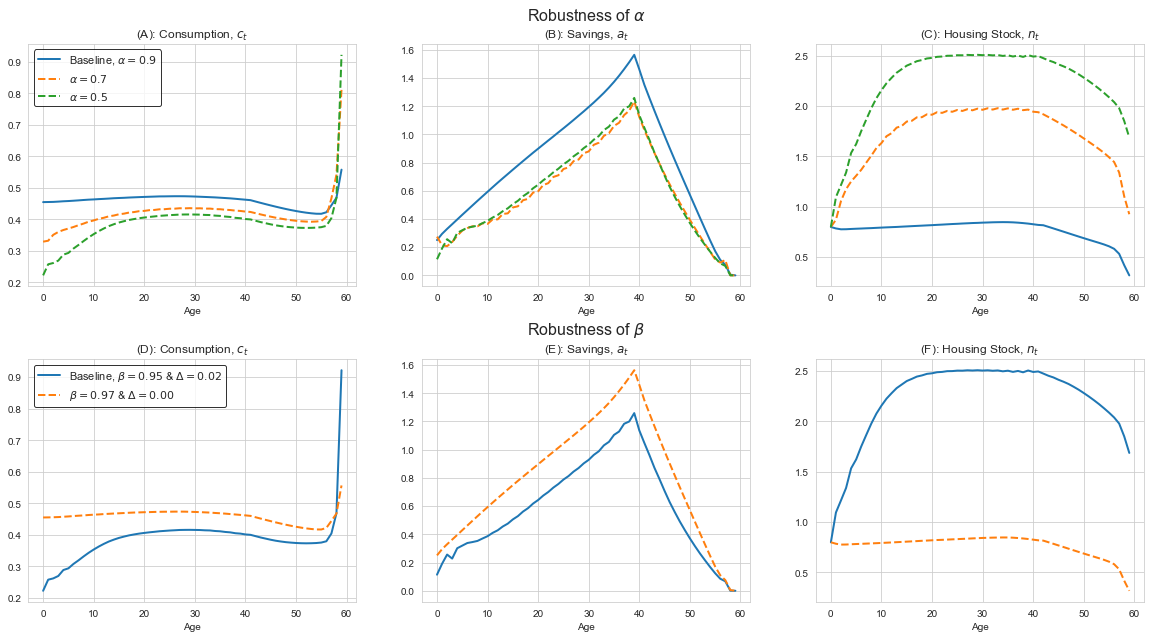

In [34]:
# a. initiate figure
fig, big_axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)

# Titles for rows
titles = ["Robustness of "+str(r'$\alpha$'), "Robustness of "+str(r'$\beta$')]

# unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_alpha1 = model_negm_baseline_alpha1.sim
sim_alpha2 = model_negm_baseline_alpha2.sim
sim_beta1 = model_negm_baseline_beta1.sim

simvarlist = [('c', 'Consumption, $c_t$'),
              ('a', 'Savings, $a_t$'),
              ('n', 'Housing Stock, $n_t$')]

# Set age
age = np.arange(par.T)

# loop over rows
for row, big_ax in enumerate(big_axes):
    big_ax.axis('off')
    big_ax.set_title(f'{titles[row]} \n', size = 16)

    # Prepare data for the plots in this row
    if row == 0:
        sims = [sim, sim_alpha1, sim_alpha2]
        labels = ["Baseline, "+str(r'$\alpha = 0.9$'), r'$\alpha = 0.7$', r'$\alpha = 0.5$']
        linestyles = ['-', '--', '--']
    else:
        sims = [sim, sim_beta1]
        labels = ['Baseline, '+str(r'$\beta = 0.95$ &')+str(r' $\Delta = 0.02$'), r'$\beta = 0.97$ &'+str(r' $\Delta = 0.00$')]
        linestyles = ['-', '--']

    # create subplots within each row
    axs = [fig.add_subplot(2, len(simvarlist), row*len(simvarlist)+i+1) for i in range(len(simvarlist))]

    for i, (simvar, simvarlatex) in enumerate(simvarlist):
        for sim, label, linestyle in zip(sims, labels, linestyles):
            simdata = getattr(sim, simvar)
            axs[i].plot(age, np.mean(simdata, axis=(1, 2)), lw=2, label=label, linestyle=linestyle)
        
        if i == 0:  # if this is the first subplot in the row
            legend = axs[i].legend(fontsize=11, frameon=True)  # creates legend with frame
            frame = legend.get_frame()  # gets the legend frame
            frame.set_edgecolor('black')  # sets the legend frame edge color
        
        axs[i].grid(True)
        axs[i].set_xlabel('Age')
        axs[i].set_title(f'({(chr(65 + row*len(simvarlist) + i))}): {simvarlatex}')

if not os.path.exists("../plots"):
    os.makedirs("../plots")
    
plt.subplots_adjust(top=0.9, hspace=0.3)
plt.savefig("../plots/two_asset_robustness.pdf", bbox_inches='tight')

plt.show()

# Discussion Graphs (not to be put in the paper)

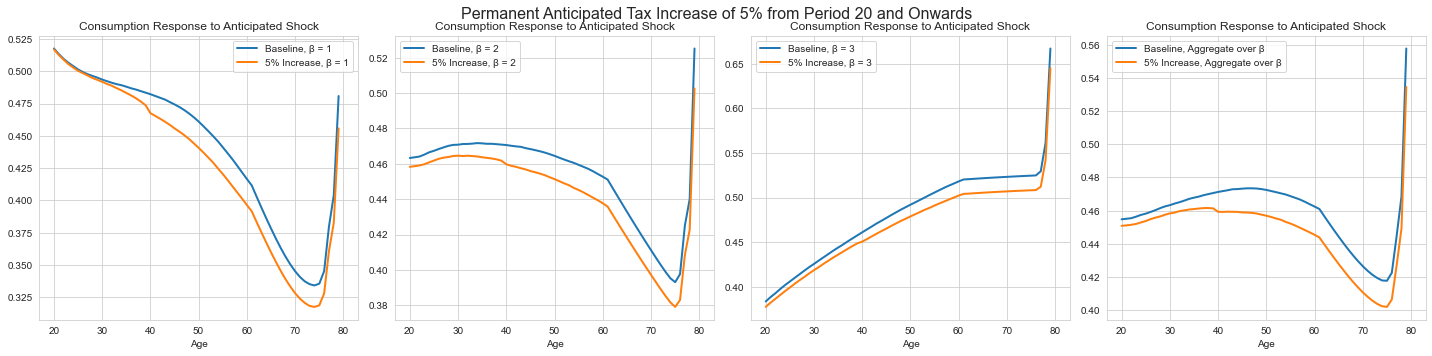

In [35]:
# a. unpack
par = model_negm_baseline.par
sim = model_negm_baseline.sim
sim_5pct = model_negm_5pct.sim

# b. figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # adjust subplot layout for 4 subplots

# add a title over the entire figure
fig.suptitle("Permanent Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

beta_values = [0, 1, 2]  # assuming beta values are these indices
labels = [f'β = {i+1}' for i in beta_values] + ['Aggregate over β']
sims = [sim, sim_5pct]

for i, ax in enumerate(axs):
    if i < 3:  # for the first three plots, we plot for each beta value
        simdata_baseline = getattr(sim, 'c')[:, beta_values[i], :]
        simdata_5pct = getattr(sim_5pct, 'c')[:, beta_values[i], :]
        ax.plot(age, np.mean(simdata_baseline, axis=1), lw=2, label=f'Baseline, β = {beta_values[i] + 1}')
        ax.plot(age, np.mean(simdata_5pct, axis=1), lw=2, label=f'5% Increase, β = {beta_values[i] + 1}')
    else:  # for the last plot, we aggregate over all beta values
        simdata_baseline = np.mean(getattr(sim, 'c'), axis=(1, 2))
        simdata_5pct = np.mean(getattr(sim_5pct, 'c'), axis=(1, 2))
        ax.plot(age, simdata_baseline, lw=2, label='Baseline, Aggregate over β')
        ax.plot(age, simdata_5pct, lw=2, label='5% Increase, Aggregate over β')

    ax.legend(frameon=True)
    ax.grid(True)
    ax.set_xlabel('Age')
    ax.set_title(f'Consumption Response to Anticipated Shock')

    # Change x-axis labels to show 20 years later
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)  # Set tick positions
    new_xticks = xticks + 20
    ax.set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    ax.set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

# Alternative Solution Methods (solve using $\delta$  = 0.15)

Solve with NVFI

In [ ]:
""" model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':False})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate() """

In [ ]:
""" # a. unpack
par = model_nvfi.par
sim = model_nvfi.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$'),
             ('p','$p_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show() """

Solve model with VFI:

In [ ]:
""" model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','do_print':False})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate() """

## Timing the model solution methods  (solve using $\delta$  = 0.15)

### Timing function

In [ ]:
def run(name = 'baseline',
        rep = 1, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

models = dict()
basename = 'results'
T = 2
base = dict()
base['T'] = T

### Timings

In [ ]:
models['negm']  = run(name=f'{basename}', solmethod='negm', updpar=base)

In [ ]:
models['nvfi']  = run(name=f'{basename}', solmethod='nvfi')

In [ ]:
#models['vfi']   = run(name=f'{basename}', solmethod='vfi')

### Time tables

In [ ]:
import tabs
#main_models = [models['negm'],models['nvfi'],models['vfi']]
main_models = [models['negm'],models['nvfi']]
tabs.all(main_models,speedup=True)